In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pymesh
#https://pymesh.readthedocs.io/en/latest/basic.html
# https://github.com/PyMesh/PyMesh

import meshplot
# for display of meshes
#https://skoch9.github.io/meshplot/tutorial/

import random

# nicer plots
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


#https://quaternion.readthedocs.io/en/latest/
import quaternion

from byorp_subs import *
# my subroutines are moved here

# shape models available here:
#https://www.naic.edu/~smarshal/1999kw4.html
#Squannit is secondary of Moshup which was 1999KW4

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### code for BYORP calculation


The surface thermal inertia is neglected, so that thermal radiation is re-emitted with no time lag, and the reflected and thermally radiated components are assumed Lambertian (isotropic) and so emitted with flux
parallel to the local surface normal. We ignore heat conduction. The surface is described with a closed
triangular mesh.


The radiation force from the $i$-th facet is
$$ {\bf F}_i  = - \frac{F_\odot}{c} {S_i} (\hat {\bf n}_i \cdot \hat {\bf s}_\odot) \hat {\bf n}_i $$
where  $S_i$ is the area of the $i$-th facet and $\hat {\bf n}_i$ is its surface normal.
Here $F_\odot$ is the solar radiation flux and $c$ is the speed of light.
The direction of the Sun is $\hat {\bf s}_\odot$.

The total Yarkovsky force is a sum over all the facets 
$${\bf F}_Y = \sum_{i: \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0} {\bf F}_i $$
Only facets on the day side  or with $\hat {\bf n}_i \cdot \hat {\bf s}_\odot >0$ 
are included in the sum.

The torque affecting the binary orbit from a single facet is 
$$ {\boldsymbol \tau}_{i,B} = 
\begin{cases} 
- \frac{F_\odot}{c} {S_i} (\hat {\bf n}_i \cdot \hat {\bf s}_\odot) ( {\bf a}_B \times \hat {\bf n}_i)  
 & \mbox{if } \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0  \\
 0 & \mbox{otherwise}
 \end{cases}
$$
where ${\bf a}_B$ is the secondary's radial vector from the binary center of mass.


The torque affecting the binary orbit is the sum of the torques from each facet and should be an average 
over the orbit around the Sun and 
over the binary orbit and spin of the secondary.
$$ {\boldsymbol \tau}_{BY} = \frac{1}{T} \int_0^T dt\   \sum_{i: \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0} 
{\boldsymbol \tau}_{i,B} $$


If $\hat {\bf l}$ is the binary orbit normal then 
$$ {\boldsymbol \tau}_{BY} \cdot \hat {\bf l} $$ 
changes the binary's orbital angular momentum and causes binary orbit migration.


The torque affecting the spin (also known as YORP) instantaneously depends on 
the radii of each facit ${\bf r}_i$ from the asteroid center of mass 
$$ {\boldsymbol \tau}_{i,s}  = \begin{cases}
- \frac{F_\odot}{c} {S_i} (\hat {\bf n}_i \cdot \hat {\bf s}_\odot)  ({\bf r}_i \times \hat{\bf n}_i) 
 & \mbox{if } \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0  \\
0 & \mbox{otherwise}
\end{cases}$$


$$ {\boldsymbol \tau}_Y = \frac{1}{T} \int_0^T dt \  \sum_{i: \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0} {\boldsymbol \tau}_{i,s} $$
where the average is done over the orbit about the Sun and the spin of the asteroid.
If the spin axis is $\hat {\boldsymbol \omega}$ then 
$$ {\boldsymbol \tau}_Y \cdot \hat {\boldsymbol \omega}  $$ gives the body spin up or spin down rate.


In practice we average over the Sun's directions first and then average over spin (for YORP) or and spin and binary orbit direction (for BYORP) afterward.


<b> Units </b> 

For our calculation are $F_\odot/c = 1$.

For YORP $R=1$.
For BYORP $a_B = 1$ and $R=1$ (in the surface area).

Here $R$ is volume equivalent sphere radius.

To put in physical units: 

Multiply ${\boldsymbol \tau}_Y$ by $\frac{F_\odot R^3}{c}$.

Multiply ${\boldsymbol \tau}_{BY}$ by $\frac{F_\odot R^2 a_B}{c}$.

Alternatively we are computing:

${\boldsymbol \tau}_Y \times \frac{c}{F_\odot R^3} $ 

${\boldsymbol \tau}_{BY} \times \frac{c}{F_\odot R^2 a_B} $ 


To get the rate the spin changes for YORP

$\dot \omega = \frac{ {\boldsymbol \tau}_Y \cdot \hat {\bf s} }{C} $

where $C$ is the moment of inertia about the spin axis.

To order of magnitude what we are computing can be multiplied by 
$\frac{F_\odot R^3}{c MR^2} $ to estimate $\dot \omega$
and by $\frac{F_\odot R^3}{c MR^2 \omega} $
to estimate $\dot \epsilon$. 

To get the rate that obliquity changes for YORP

$\dot \epsilon = \frac{ {\boldsymbol \tau}_Y \cdot \hat {\boldsymbol \phi} }{C \omega} $

where unit vector $\hat {\boldsymbol \phi}$ is in the xy plane (ecliptic) and is perpendicular to the spin axis.

To get the semi-major axis drift rate for BYORP

$ \dot a_B = \frac{2 {\boldsymbol \tau}_{BY} \cdot \hat {\bf l}}{M n_Ba_B} $

where $M$ is the secondary mass, $n_B$ and $a_B$ are binary orbit mean motion and semi-major axis.

To order of magnitude to get the drift rate we multiply what we are getting by 
$\frac{F_\odot R^2 a_B}{c} \times \frac{1}{M n_B a_B}$.


Dimensionless numbers used by Steiberg+10 (eqns 19,48)

$f_{Y} \equiv \tau_{Y} \frac{3}{2} \frac{c}{\pi R^3 F_\odot}$

$f_{BY} \equiv \tau_{BY} \frac{3}{2} \frac{c}{\pi R^2 a_B F_\odot}$

Our computed values are  the same as theirs except for a factor of 3/2 
(but they have a 2/3 in their torque) and a factor of $\pi$.
We need to divide by $\pi$ to have values consistent with theirs.

<b> Assumptions:</b>

Circular orbit for binary.

Circuilar orbit for binary around Sun.

No shadows.

No conduction. Lambertian isotropic emission. No thermal lag.

We neglect distance of facet centroids from secondary center of mass when computing BYORP. 

Coordinate system:
binary orbit is kept in xy plane

Compare YORP on primary to BYORP on secondary.

$\frac{\tau_{Yp}}{\tau_{BY} }\sim \frac{R_p^2 }{R_s^2 } \frac{R_p }{a_B }\frac{f_Y}{ f_{BY}}$

For Didymos, this is about $8 f_Y/f_{BY}$.

In [2]:
random.seed(1)
print(random.uniform(-1,1))

-0.7312715117751976


### Sun position needs to be averaged to take into account precession
Then we can remove random choice of phi_prec in obliquity calculation

In [2]:


# compute radiation forces F_i for each face, but averaging over all positions of the Sun
# a circular orbit for the asteroid is assumed
# we tilt Sun's orbit along x axis arbitrarily
# arguments: 
#    f_areas a vector of face areas
#    f_normals a vector of face normals
#    nphi_Sun is the number of solar angles, evenly spaced in 2pi so we are assuming circular orbit
#    incl is solar orbit inclination in radians
# returns: F_i_x average and other 2 components of forces for each facet
def F_i_sun_ave(f_areas,f_normals,nphi_Sun,incl):
    dphi = 2*np.pi/nphi_Sun
    # compute the first set of forces so we have vectors the right length
    phi = 0.0
    #s_hat = np.array([np.cos(phi)*np.cos(incl),np.sin(phi)*np.cos(incl),np.sin(incl)])
    s_hat = np.array([np.cos(phi),np.sin(phi)*np.cos(incl),np.sin(phi)*np.sin(incl)])
    # compute the radiation force instantaneously on the triangular mesh for sun at s_hat
    F_i_x_sum,F_i_y_sum,F_i_z_sum = F_i(f_areas,f_normals,s_hat)
    # now compute the forces for the rest of the solar angles
    for i in range(1,nphi_Sun): # do the rest of the angles
        phi = i*dphi
        #s_hat = np.array([np.cos(phi)*np.cos(incl),np.sin(phi)*np.cos(incl),np.sin(incl)])
        s_hat = np.array([np.cos(phi),np.sin(phi)*np.cos(incl),np.sin(phi)*np.sin(incl)])
        # if incl = 0, then orbit is in xy plane (cos phi,sin phi, 0)
        # if incl = 90 then orbit  is (cos phi,0, sin phi)
        # if incl = 180 then orbit is (cos phi, -sin phi,0)
        # compute the radiation force instantaneously on the triangular mesh for sun at s_hat
        F_i_x,F_i_y,F_i_z = F_i(f_areas,f_normals,s_hat)  
        # These are vectors of length number of facets
        F_i_x_sum += F_i_x  # sum up forces
        F_i_y_sum += F_i_y
        F_i_z_sum += F_i_z
    F_i_x_ave = F_i_x_sum/nphi_Sun  # average
    F_i_y_ave = F_i_y_sum/nphi_Sun
    F_i_z_ave = F_i_z_sum/nphi_Sun
    return F_i_x_ave,F_i_y_ave,F_i_z_ave  # these are vectors for each face


# compute total BYORP averaging over nphi_Sun solar positions
# for a single binary vector a_bin and body position described with mesh
# arguments:
#    f_areas a vector of face areas
#    f_normals a vector of face normals
#    incl is solar orbit inclination in radians
#    nphi_Sun is the number of solar angles
#    a_bin is binary direction unit vector
# returns: torque components
def tau_Bs(f_areas,f_normals,nphi_Sun,incl,a_bin):
    # compute F_i for each face, but averaging over all positions of the Sun
    F_i_x_ave, F_i_y_ave,F_i_z_ave = F_i_sun_ave(f_areas,f_normals,nphi_Sun,incl) 
    # these are vectors length number of faces
    # forces from day lit faces
    F_x = np.sum(F_i_x_ave)  #sum up the force
    F_y = np.sum(F_i_y_ave)
    F_z = np.sum(F_i_z_ave)
    a_x = a_bin[0]  # binary direction
    a_y = a_bin[1]
    a_z = a_bin[2]
    tau_x,tau_y,tau_z = cross_prod_xyz(a_x,a_y,a_z,F_x,F_y,F_z) # cross product
    return tau_x,tau_y,tau_z  # these are numbers that give the torque components
        

In [3]:


# tilt over the body vertices by obliquity which is an angle in radians
# then rotate about short axis by phi (in radians)
# arguments:
#    vertices: triangular mesh surface vertices for body
#    obliquity: angle in radius to tilt body z axis over
#    phi: angle in radians to spin/rotate body about its z axis
#    phi_prec,  angle in randias that tilt is done, it's a precession angle
#      sets rotation axis for tilt, this axis is in the xy plane
# returns: 
#     new vertices: the tilted/rotated mesh vertices
#     zrot:  the new z-body short spin axis
#     xrot:  the new long  axis
def tilt_obliq(vertices,obliquity,phi,phi_prec):

    v = np.copy(vertices)
    zaxis = np.array([0,0,1])
    xaxis = np.array([1,0,0])
    
    # tilt by obliquity
    axist = np.array([np.cos(phi_prec),np.sin(phi_prec),0])  # precession angle is phi_prec
    qt = quaternion.from_rotation_vector(rot=axist*obliquity)     # tilt    
    vp=quaternion.rotate_vectors(qt, v)   # rotate vectors, tilt over
    zrot = quaternion.rotate_vectors(qt,zaxis) # body principal axis will become zrot, short axis
    xrot = quaternion.rotate_vectors(qt,xaxis)  # long axis
    
    # rotate about short axis
    qs = quaternion.from_rotation_vector(rot=zrot*phi)    # spin rotation
    vpp = quaternion.rotate_vectors(qs, vp)   # rotate vectors spin
    xrot = quaternion.rotate_vectors(qs,xrot)
    # zrot stays the same
    return vpp,zrot,xrot

# arguments:
#  phi: rotate about short axis by this angle (in radians)
#  stilt: rotate about long axis by this angle 
#  linc:  tilt long axis by this inclination
# returns: 
#     new vertices: the tilted/rotated mesh vertices
#     zrot:  the new z-body short spin axis
#     xrot:  the new  long  axis
def short_axis_tilt(vertices,phi,stilt,linc):
    v = np.copy(vertices)
    zaxis = np.array([0,0,1])
    xaxis = np.array([1,0,0])
    
    # rotate about short axis by phi
    qs = quaternion.from_rotation_vector(rot=zaxis*phi)     # spin it
    xrot = quaternion.rotate_vectors(qs,xaxis)  #long axis
    # zaxis stays the same
    vp = quaternion.rotate_vectors(qs, v)   # rotate vectors
   
    # short axis tilt rotate about long body axis
    ql = quaternion.from_rotation_vector(rot=xrot*stilt)  # short axis tilt
    #xrot  stays the same
    zrot = quaternion.rotate_vectors(ql,zaxis)  # short axis
    vpp  = quaternion.rotate_vectors(ql, vp)   # rotate vectors
    
    # now tilt long axis out of plane
    Cx,Cy,Cz = cross_prod_xyz(xrot[0],xrot[1],xrot[2],0,0,1)
    Caxis = np.array([Cx,Cy,Cz])
    Caxis /= np.sqrt(Cx**2 + Cy**2 + Cz**2)  # make sure is a unit vector
    # a vector in xy plane that is perp to long axis and z axis
    qt = quaternion.from_rotation_vector(rot=Caxis*linc)  # long axis inclination tilt
    xrot = quaternion.rotate_vectors(qt,xrot)
    zrot = quaternion.rotate_vectors(qt,zrot)
    vppp = quaternion.rotate_vectors(qt, vpp)   # rotate vectors
    
    return vppp,zrot,xrot
    

# tilt,spin a body and compute binary direction, assuming tidally locked
# arguments:
#   vertices of a mesh body (in principal axis coordinate system)
#   nphi is the number of angles that could be done with indexing by iphi
#   iphi:  number of rotations by dphi where dphi = 2pi/nphi
#      this is principal axis rotation about z axis
#   phi0: an offset for phi applied to body but not binary axis, similar to a libration angle, but not quite
#      as is not projected onto orbital plane, is an offset in rotation angle
#   tilt_type: 1 or 2 
#   if tilt_type==1 then 
#      tilt_angle1 = obliquity 
#          obliquity:  w.r.t to binary orbit angular momentum direction
#      tilt_angle2 = phi_prec
#           phi_prec: a precession angle for tilting
#   if tilt_type==2 then
#      tilt_angle1 = maxtilt which gives short axis tilt stilt
#      tilt_angle2 = long axis inclination lic
# returns: 
#   tvertices, a body of rotated vertices 
#   a_bin, binary direction assuming same rotation rate, tidal lock
#   l_bin:  binary orbit angular momentum orbital axis
#   zrot:  short axis direction 
#   xrot:  long axis direction 
def tilt_and_bin(vertices,nphi,iphi,phi0,tilt_type,tilt_angle1,tilt_angle2):
                 
    dphi = 2*np.pi/nphi
    phi = iphi*dphi 
    if (tilt_type ==1):
        obliquity = tilt_angle1; #phi_prec = tilt_angle2
        phi_lib = random.uniform(-phi0,phi0)
        phi_prec = random.uniform(0,2*np.pi)
        tvertices,zrot,xrot = tilt_obliq(vertices,obliquity,phi + phi_lib,phi_prec)  # tilt and spin body
        # phi_lib and phi_prec could be randomized here
        
    if (tilt_type ==2):
        maxtilt = tilt_angle1
        stilt = random.uniform(-maxtilt,maxtilt)
        phi_lib = random.uniform(-phi0,phi0)
        mlinc = tilt_angle2
        linc = random.uniform(-mlinc,mlinc)
        tvertices,zrot,xrot = short_axis_tilt(vertices,phi + phi_lib,stilt,linc)  # tilt and spin body
        
    a_bin = np.array([np.cos(phi),np.sin(phi),0.0])   # direction to binary
    l_bin = np.array([0,0,1.0])  # angular momentum axis of binary orbit
    return tvertices,a_bin,l_bin,zrot,xrot

In [4]:
# compute the BYORP torque, for a tidally locked binary
# arguments:
#   body:  triangular surface mesh (in principal axis coordinate system)
#   nphi is the number of body angles we will use (spin)
#   obliquity is body tilt w.r.t to binary orbit
#   incl is solar orbit inclination 
#   nphi_Sun is the number of solar angles used
#   phi0 an offset for body spin angle that is not applied to binary direction
#   phi_prec  z-axis precession angle, relevant for obliquity 
# returns:
#   3 torque components
#   torque dot l_bin so can compute binary orbit drift rate
def compute_BY(vertices,faces,nphi,nphi_Sun,incl,phi0,tilt_type,tilt_angle1,tilt_angle2):
    tau_BY_x = 0.0
    tau_BY_y = 0.0
    tau_BY_z = 0.0
    for iphi in range(nphi):  # body positions
        # rotate the body and tilt it over, and find binary direction
        tvertices,a_bin,l_bin,zrot,xrot = tilt_and_bin(vertices,\
                                            nphi,iphi,phi0,tilt_type,tilt_angle1,tilt_angle2)
        # rotated body is in tvertices
        # now recompute face areas and surface normal directions
        f_areas, f_normals = face_areas(tvertices,faces) # vector of facet areas and face normal vectors
        # of the rotated body, faces don't change
        # a_bin is binary direction
        # compute torques 
        tau_x,tau_y,tau_z =tau_Bs(f_areas,f_normals,nphi_Sun,incl,a_bin)  # incl and a_bin here
        tau_BY_x += tau_x
        tau_BY_y += tau_y
        tau_BY_z += tau_z
        
    tau_BY_x /= nphi  # average
    tau_BY_y /= nphi
    tau_BY_z /= nphi
    
    # recompute l_bin
    tvertices,a_bin,l_bin,zrot,xrot = tilt_and_bin(vertices,\
                                        nphi,iphi,phi0,tilt_type,tilt_angle1,tilt_angle2)
         
    # compute component that affects binary orbit angular momentum
    # this is tau dot l_bin
    tau_l = tau_BY_x*l_bin[0] + tau_BY_y*l_bin[1] + tau_BY_z*l_bin[2] 
    return tau_BY_x,tau_BY_y,tau_BY_z, tau_l 

In [73]:

# compute the BYORP torque on body as a function of obliquity
# for a given inclination and precession angle, and rotation offset angle phi0
# returns obliquity and torque arrays
# arguments:
#  incl: inclination in radians
#  phi_prec: precession angle in radians
#  phi0: lib angle in radians
# returns:
#  o_arr: array of obliquities in degrees
#  tau_l_arr: array of Byorp B coeffs
def obliq_BY_fig2(vertices,faces,incl,phi_prec,phi0):
    #phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    nobliq = 60   # number of obliquities
    dobliq = np.pi/nobliq
    tau_l_arr = np.zeros(nobliq)  # to store torques
    o_arr = np.zeros(nobliq)
    tilt_type = 1 # obliquity tilt
    tilt_angle2 = phi_prec
    for i in range(nobliq):
        obliquity=i*dobliq
        tilt_angle1 = obliquity
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l =\
            compute_BY(vertices,faces,nphi,nphi_Sun,incl,phi0,tilt_type,tilt_angle1,tilt_angle2)
        o_arr[i] = obliquity*180/np.pi
        tau_l_arr[i] = tau_l
    tau_l_arr *= 2.0/3.0 # Lambertian correction
    return o_arr,tau_l_arr



# compute the BYORP torque on body as a function of max_tilt angle
# for a given inclination and precession angle, and rotation offset angle phi0
# returns obliquity and torque arrays
# arguments:
#  angles in radians
#  incl: inclination of Sun
#  phi0: lib angle
#  maxtilt_range:  how far over short axis tilt is allowed
#  tilt_angle2: not used right now
#  ntilt, number of tilts to do
# returns:
#  o_arr: array of max tilt angles in degrees
#  tau_l_arr: array of Byorp B coeffs
def tilt_BY_fig1(vertices,faces,incl,phi0,maxtilt_range,tilt_angle2,ntilt):
    #phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36*4    # number of spin positions
    #ntilt = 30   # number of tilts
    dtilt = maxtilt_range/ntilt
    tau_l_arr = np.zeros(ntilt)  # to store torques
    o_arr = np.zeros(ntilt)
    
    tilt_type = 2 # short axis tilt


    for i in range(ntilt):
        maxtilt=i*dtilt
        tilt_angle1 = maxtilt
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l =\
            compute_BY(vertices,faces,nphi,nphi_Sun,incl,phi0,tilt_type,tilt_angle1,tilt_angle2)
        o_arr[i] = maxtilt*180/np.pi
        tau_l_arr[i] = tau_l
    tau_l_arr *= 2.0/3.0 # Lambertian correction
    return o_arr,tau_l_arr

### now create meshes

In [10]:
# create a sphere of radius 1
center = np.array([0,0,0])
sphere = pymesh.generate_icosphere(1., center, refinement_order=2)
sphere.add_attribute("face_area")
sphere.add_attribute("face_normal")
sphere.add_attribute("face_centroid")
print(volume_mesh(sphere))
nf_mesh(sphere)

# create a perturbed ellipsoid using the above sphere
devrand = 0.05  # perturbation size  # fiducial model
aratio1 = 0.5   # axis ratios c/a
aratio2 = 0.7   # b/a
random.seed(2)  # fix the sequence
psphere1 = sphere_perturb(sphere,devrand,1,1)  #perturbed sphere 
body1 = body_stretch(psphere1,aratio1,aratio2)  # stretch 
#print(volume_mesh(body1))  #check volume


4.047005367354512
number of faces  320


In [11]:
devrand = 0.025  # perturbation size larger
random.seed(2)  # same perturbations
psphere2 = sphere_perturb(sphere,devrand,1,1)  #less perturbed sphere 
aratio1 = 0.5   # same axis ratios
aratio2 = 0.7
body2 = body_stretch(psphere2,aratio1,aratio2)

devrand = 0.05  # perturbation size same as fiducial
random.seed(21)  # different perturbations
psphere3 = sphere_perturb(sphere,devrand,1,1)  #fid perturbed sphere 
aratio1 = 0.5   # same axis ratios
aratio2 = 0.7
body3 = body_stretch(psphere3,aratio1,aratio2)


devrand = 0.05  # perturbation size same as fiducial
random.seed(25)  # different perturbations
psphere4 = sphere_perturb(sphere,devrand,1,1)  #fid perturbed sphere 
aratio1 = 0.5   # same axis ratios
aratio2 = 0.7
body4 = body_stretch(psphere4,aratio1,aratio2)


devrand = 0.05  # perturbation size same as fiducial
random.seed(29)  # different perturbations
psphere5 = sphere_perturb(sphere,devrand,1,1)  #fid perturbed sphere 
aratio1 = 0.5   # same axis ratios
aratio2 = 0.7
body5 = body_stretch(psphere5,aratio1,aratio2)

devrand = 0.05  # perturbation size same as fiducial
random.seed(31)  # different perturbations
psphere6 = sphere_perturb(sphere,devrand,1,1)  #fid perturbed sphere 
aratio1 = 0.5   # same axis ratios
aratio2 = 0.7
body6 = body_stretch(psphere6,aratio1,aratio2)



In [12]:

aratio1 = 0.5   # new axis ratios
aratio2 = 0.8
body1a = body_stretch(psphere1,aratio1,aratio2)

aratio1 = 0.6   # new axis ratios
aratio2 = 0.7
body1b = body_stretch(psphere1,aratio1,aratio2)


aratio1 = 0.4   # new axis ratios
aratio2 = 0.9
body1c = body_stretch(psphere1,aratio1,aratio2)



In [13]:
S_i, f_normals = face_areas(body1.vertices,body1.faces)
#d = meshplot.subplot(body1.vertices, body1.faces, c=v[:, 1], s=[2, 2, 2])
d=meshplot.subplot(body1.vertices, body1.faces, c=S_i, s=[2, 2, 2])
meshplot.subplot(body1.vertices, body1.faces, c=f_normals[:,2], s=[2, 2, 2])

In [14]:
xmax = 1.5
p = plt_mesh_square(body1.vertices,body1.faces,xmax)  # body1 xy plane
# p.save('junk.html')  # works but no way to snap or get orientation 
xrot = np.array([1,0,0])
vrot = rotate_vertices(body1.vertices,xrot,np.pi/2)
p = plt_mesh_square(vrot,body1.faces,xmax)  # body 1 xz plane

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.026061…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.026061…

In [15]:
xmax = 1.5
p = plt_mesh_square(body2.vertices,body1.faces,xmax) # body 2 xy plane
xrot = np.array([1,0,0])
vrot = rotate_vertices(body2.vertices,xrot,np.pi/2)
p = plt_mesh_square(vrot,body2.faces,xmax)  # body 2 xz plane

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.013030…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.013030…

In [16]:
# check total surface area
print(surface_area(sphere))
print(surface_area(psphere1))
print(surface_area(psphere2))
print(surface_area(psphere3))
print(surface_area(body1))
print(surface_area(body2))
print(surface_area(body3))
print(surface_area(body1a))
print(surface_area(body1b))

# subtract 1 and you have approximately the d_s used by Steinberg+10
# many of their d_s are  lower (see their figure 3)

0.9811156432317085
1.003830499198687
0.9883108907346502
0.9992616460925486
1.0664364654025773
1.050536574113009
1.0643474288238175
1.072882983618328
1.0380017699710702


In [17]:
#https://www.naic.edu/~smarshal/1999kw4.html
#Squannit is secondary of Moshup which was 1999KW4

squannit = pymesh.load_mesh("kw4b.obj")
nf_mesh(squannit)  # compute numbers of faces
# we need to normalize it so that its volume is 4/3 pi
# to compute the volume of a tetrahdon that is made from a face + a vertex at the origin 
# we need to compute the determanent of a 3x3 matrix that consists of the 3 vertices in the face.
# we then sum over all faces in the mesh to get the total volume
# alternatively we use the generalized voxel thing in pymesh which is 4 vertices.
# to do this we add a vertex at the center and then we need to make the same number
# of voxels as faces using the vertex at the origin.
# and then we sum over the voxel_volume attributes of all the voxels.
xmax = 1.5
#p = plt_mesh_square(squannit.vertices,squannit.faces,xmax)

number of faces  2292


In [19]:
vol = volume_mesh(squannit)
print(vol)
R_squannit = pow(vol*3/(4.0*np.pi),0.3333333)
print(R_squannit)  # I don't know what units this is in. maybe km
# the object is supposed to have Beta: 0.571 x 0. 463 x 0.349 km (6% uncertainty)
# Rescale squannit shape model so it has vol equiv sphere radius of 1
new_squannit = cor_volume(squannit)
p = plt_mesh_square(new_squannit.vertices,new_squannit.faces,xmax)
# first snap of squannit xy plane

# second snap of rescaled squannit xz plane
xrot = np.array([1,0,0])
vrot = rotate_vertices(new_squannit.vertices,xrot,np.pi/2)
p = plt_mesh_square(vrot,new_squannit.faces,xmax)

0.048034509370524114
0.22550437981398924
Volume 0.0480
radius of vol equ sphere 0.2255
new Volume 4.189


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.012110…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.012110…

In [20]:
# reduce the number of faces to something reasonable
short_squannit1, info = pymesh.collapse_short_edges(new_squannit, 0.219)  # number if bigger then fewer faces
nf_mesh(short_squannit1)  # print number of faces
pymesh.save_mesh("short_squannit1.obj", short_squannit1, ascii=True)
#meshplot.plot(short_squannit1.vertices, short_squannit1.faces)  # xy plane snap
short_squannit2, info = pymesh.collapse_short_edges(new_squannit, 0.17)  # if bigger then fewer faces
nf_mesh(short_squannit2)
#meshplot.plot(short_squannit2.vertices, short_squannit2.faces) # xy plane snap
pymesh.save_mesh("short_squannit2.obj", short_squannit2, ascii=True)


xrot = np.array([1,0,0])
vrot1 = rotate_vertices(short_squannit1.vertices,xrot,np.pi/2)  # for coarse squannit 302 xz plane snap
vrot2 = rotate_vertices(short_squannit2.vertices,xrot,np.pi/2)  # for coarse squannit 534 xz plane snap

number of faces  302
number of faces  534


In [61]:
p=plt_mesh_square(vrot2,short_squannit2.faces,0.1)  # coarse squannit xz plane snap

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.013201…

In [21]:
# snaps for coarse squannit 534
p = plt_mesh_square(short_squannit2.vertices,short_squannit2.faces,xmax) # coarse squannit xy plane snap
p = plt_mesh_square(vrot2,short_squannit2.faces,xmax)  # coarse squannit xz plane snap

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.012885…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.012885…

In [57]:
#  perturbed squannit models
devrand=0.05; random.seed(29) 
short_squannit2_p  = sphere_perturb(short_squannit2,devrand,1,1)
pymesh.save_mesh("short_squannit2_p.obj", short_squannit2, ascii=True)
#  perturbed squannit model 
devrand=0.05; random.seed(29) 
short_squannit1_p  = sphere_perturb(short_squannit1,devrand,1,1)
pymesh.save_mesh("short_squannit1_p.obj", short_squannit1_p, ascii=True)  # 302

#  perturbed squannit model 
devrand=0.05; random.seed(31) 
short_squannit1_pb  = sphere_perturb(short_squannit1,devrand,1,1)
pymesh.save_mesh("short_squannit1_pb.obj", short_squannit1_pb, ascii=True)  # 302


# snaps for perturbed sqannit 534
p = plt_mesh_square(short_squannit2_p.vertices,short_squannit2_p.faces,xmax)  # xy plane perturbed squanit 534
xrot = np.array([1,0,0])
vrot2 = rotate_vertices(short_squannit2_p.vertices,xrot,np.pi/2)
p = plt_mesh_square(vrot2,short_squannit2_p.faces,xmax)  # xz plane snap perturbed squanit 534


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.013201…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.013201…

In [23]:
# make the squannit model a bit thinner 
aratio1 = 0.8; aratio2=1
short_squannit2_tmp=body_stretch(short_squannit2,aratio1,aratio2)
short_squannit3 = cor_volume(short_squannit2_tmp)

# shapes for thin squannit2 534
p = plt_mesh_square(short_squannit3.vertices,short_squannit3.faces,xmax)  # xy plane
xrot = np.array([1,0,0])
vrot3 = rotate_vertices(short_squannit3.vertices,xrot,np.pi/2)  # for coarse squannit xz plane snap
p = plt_mesh_square(vrot3,short_squannit3.faces,xmax)  # xz plane snap

Volume 4.0603
radius of vol equ sphere 0.9897
new Volume 4.189


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.010216…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.010216…

In [24]:
# snaps for squannit 302
p = plt_mesh_square(short_squannit1.vertices,short_squannit1.faces,xmax)  # xy plane  squannit 302
xrot = np.array([1,0,0])
vrot1 = rotate_vertices(short_squannit1.vertices,xrot,np.pi/2)
p = plt_mesh_square(vrot1,short_squannit1.faces,xmax)  # xz plane snap  squannit 302


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.011542…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.011542…

In [25]:
# snaps for perturbed squannit 302
p = plt_mesh_square(short_squannit1_p.vertices,short_squannit1_p.faces,xmax)  # xy plane perturbed squannit 302
xrot = np.array([1,0,0])
vrot1 = rotate_vertices(short_squannit1_p.vertices,xrot,np.pi/2)
p = plt_mesh_square(vrot1,short_squannit1_p.faces,xmax)  # xz plane snap perturbed squannit 302


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.023930…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.023930…

In [223]:
v_cmshift = np.copy(short_squannit2.vertices)
v_cmshift[:,0] -= 0.05 # shift the center of mass in x direction 
short_squannit4 =  pymesh.form_mesh(v_cmshift, short_squannit2.faces)



### now compute BYORPs and make figures!

In [74]:
incl = 0;  phi0=0; tilt_angle2=0; maxtilt_range = np.pi; 
ntilt=60
# squannit, how many faces and scatter 
m_arr_s1,mtau_l_arr_s1 = tilt_BY_fig1(short_squannit1.vertices,short_squannit1.faces,\
                                       incl,phi0,maxtilt_range,tilt_angle2,ntilt)

In [75]:
# perturbed squannit  
ntilt=60
m_arr_sp,mtau_l_arr_sp = tilt_BY_fig1(short_squannit1_p.vertices,short_squannit1_p.faces,\
                                        incl,phi0,maxtilt_range,tilt_angle2,ntilt)


In [66]:
# another perturbed squannit  if you want to check it
#m_arr_spb,mtau_l_arr_spb = tilt_BY_fig1(short_squannit1_pb.vertices,short_squannit1_pb.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2,ntilt)


In [76]:
# icosphere
ntilt=30
m_arr_s ,mtau_l_arr_s =  tilt_BY_fig1(sphere.vertices,sphere.faces,\
                                      incl,phi0,maxtilt_range,tilt_angle2,ntilt)

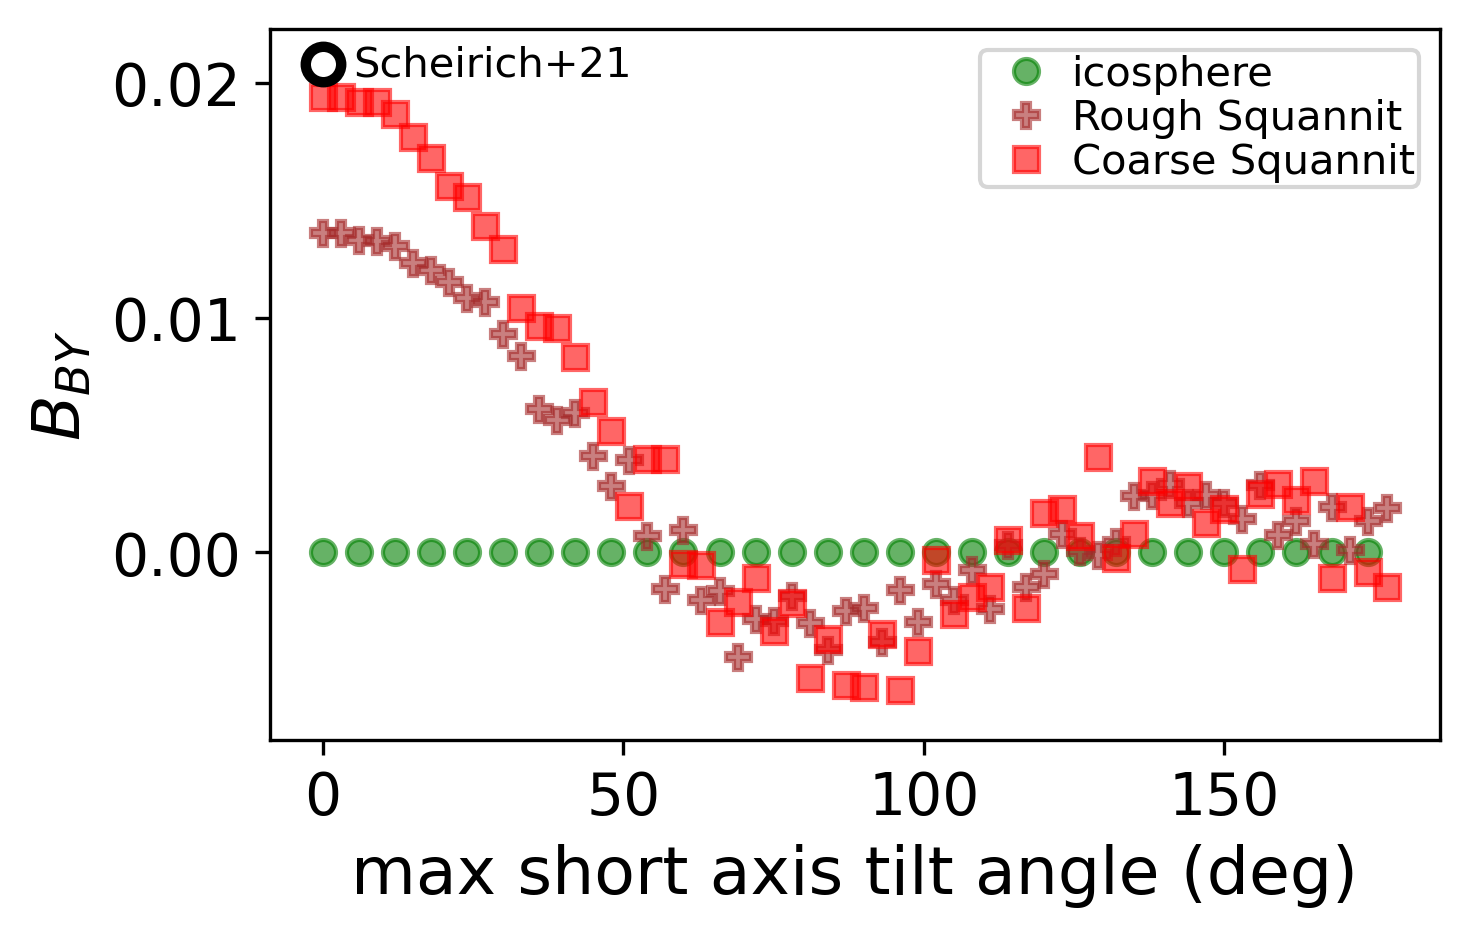

In [77]:
fig,ax = plt.subplots(1,1,figsize=(5,3),dpi=300,sharex=True,sharey=True)
plt.subplots_adjust(bottom=0.19,top=0.98,left=0.2, right=0.98,wspace=0,hspace=0) 

ax.set_ylim((-0.008,0.0223))

ax.plot(m_arr_s,mtau_l_arr_s,'o',alpha=0.6,color='green',label='icosphere')
ax.plot(m_arr_sp,-mtau_l_arr_sp,'P',alpha=0.6,color='brown',label=r'Rough Squannit')
ax.plot(m_arr_s1,-mtau_l_arr_s1,'s',alpha=0.6,color='red',label='Coarse Squannit')

#ax.plot(m_arr_spb,-mtau_l_arr_spb,'P',alpha=0.6,color='blue',label=r'S302 $\Delta$=0.05')

ax.set_xlabel('max short axis tilt angle (deg)',fontsize=16)
#ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.set_ylabel(r'$B_{BY}$',fontsize=16)

ax.legend(borderpad=0.1,labelspacing=0.1,handletextpad=0.1,loc='upper right',ncol=1)

Bnom = 2.082e-2
ax.plot([0],[Bnom],marker='o',color='black',fillstyle='none',ms=10,lw=5)
ax.plot([0],[Bnom],marker='o',color='black',fillstyle='none',ms=9,lw=5)
ax.plot([0],[Bnom],marker='o',color='black',fillstyle='none',ms=8,lw=5)
ax.plot([0],[Bnom],marker='o',color='black',fillstyle='none',ms=7,lw=5)
ax.text(5,0.0203,'Scheirich+21')
plt.savefig('tau_BY_tilt_new.png')

In [23]:
# compute BYORPs as a function of maxtilt range
incl = 0;  phi0=0; tilt_angle2=0
maxtilt_range = np.pi
m_arr1 ,mtau_l_arr1 =  tilt_BY_fig1(body1.vertices,body1.faces,incl,phi0,maxtilt_range,tilt_angle2)
m_arr_s ,mtau_l_arr_s =  tilt_BY_fig1(sphere.vertices,sphere.faces,incl,phi0,maxtilt_range,tilt_angle2)


In [24]:
# different perturbations
m_arr2 ,mtau_l_arr2 =  tilt_BY_fig1(body2.vertices,body2.faces,incl,phi0,maxtilt_range,tilt_angle2)
m_arr3 ,mtau_l_arr3 =  tilt_BY_fig1(body3.vertices,body3.faces,incl,phi0,maxtilt_range,tilt_angle2)
m_arr4 ,mtau_l_arr4 =  tilt_BY_fig1(body4.vertices,body4.faces,incl,phi0,maxtilt_range,tilt_angle2)
m_arr5 ,mtau_l_arr5 =  tilt_BY_fig1(body5.vertices,body5.faces,incl,phi0,maxtilt_range,tilt_angle2)
m_arr6 ,mtau_l_arr6 =  tilt_BY_fig1(body6.vertices,body6.faces,incl,phi0,maxtilt_range,tilt_angle2)


In [25]:
# different axis ratios
m_arr1a ,mtau_l_arr1a =  tilt_BY_fig1(body1a.vertices,body1a.faces,incl,phi0,maxtilt_range,tilt_angle2)
m_arr1b ,mtau_l_arr1b =  tilt_BY_fig1(body1b.vertices,body1b.faces,incl,phi0,maxtilt_range,tilt_angle2)
m_arr1c ,mtau_l_arr1c =  tilt_BY_fig1(body1c.vertices,body1c.faces,incl,phi0,maxtilt_range,tilt_angle2)

In [26]:
# tilt inclination of long axis 
tilt_angle2= 30.*np.pi/180
m_arr1d ,mtau_l_arr1d =  tilt_BY_fig1(body1.vertices,body1.faces,incl,phi0,maxtilt_range,tilt_angle2)
tilt_angle2=0 # reset

# libration 
phi0=20.*np.pi/180;
m_arr1e ,mtau_l_arr1e =  tilt_BY_fig1(body1.vertices,body1.faces,incl,phi0,maxtilt_range,tilt_angle2)
phi0=0; # reset

In [29]:
incl = 0;  phi0=0; tilt_angle2=0; maxtilt_range = np.pi
# squannit, how many faces and scatter 
m_arr_s1,mtau_l_arr_s1 = tilt_BY_fig1(short_squannit1.vertices,short_squannit1.faces,\
                                       incl,phi0,maxtilt_range,tilt_angle2)
#m_arr_s2,mtau_l_arr_s2 = tilt_BY_fig1(short_squannit2.vertices,short_squannit2.faces,\
#                                       incl,phi0,maxtilt_range,tilt_angle2)
#m_arr_s2a,mtau_l_arr_s2a = tilt_BY_fig1(short_squannit2.vertices,short_squannit2.faces,\
#                                       incl,phi0,maxtilt_range,tilt_angle2)

# squannit vary vtilt
#tilt_angle2= 30.*np.pi/180
#m_arr_s4d,mtau_l_arr_s4d = tilt_BY_fig1(short_squannit1.vertices,short_squannit1.faces,\
#                                      incl,phi0,maxtilt_range,tilt_angle2)
#tilt_angle2=0 # reset

# squannit phi_lib vary i=0
#phi0= 20.*np.pi/180
#m_arr_s4f,mtau_l_arr_s4f = tilt_BY_fig1(short_squannit2.vertices,short_squannit2.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#phi0=0; # reset

# squannit phi_lib vary i=0, vtilt vary
#phi0= 20.*np.pi/180; tilt_angle2= 30.*np.pi/180
#m_arr_s4i,mtau_l_arr_s4i = tilt_BY_fig1(short_squannit2.vertices,short_squannit2.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#phi0=0; tilt_angle2= 0. # reset


In [28]:
# squannit thinner 
#m_arr_s3,mtau_l_arr_s3 = tilt_BY_fig1(short_squannit3.vertices,short_squannit3.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)

# thin squannit, vtilt
#tilt_angle2= 30.*np.pi/180
#m_arr_s3b,mtau_l_arr_s3b = tilt_BY_fig1(short_squannit3.vertices,short_squannit3.faces,\
#                                      incl,phi0,maxtilt_range,tilt_angle2)
#tilt_angle2=0 # reset


In [31]:
# perturbed squannit  i=0
m_arr_sp,mtau_l_arr_sp = tilt_BY_fig1(short_squannit1_p.vertices,short_squannit1_p.faces,\
                                        incl,phi0,maxtilt_range,tilt_angle2)

# perturbed squannit  i=0, vtilt
#tilt_angle2= 30.*np.pi/180
#m_arr_spb,mtau_l_arr_spb = tilt_BY_fig1(short_squannit2_p.vertices,short_squannit2_p.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#tilt_angle2=0 # reset

In [30]:
# squannit vary incl
#incl = 20.*np.pi/180; 
#m_arr_s4a,mtau_l_arr_s4a = tilt_BY_fig1(short_squannit2.vertices,short_squannit2.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#incl = 160.*np.pi/180; 
#m_arr_s4b,mtau_l_arr_s4b = tilt_BY_fig1(short_squannit2.vertices,short_squannit2.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#incl=0 # reset                                      

In [256]:
#incl = 160.*np.pi/180;   # incl scatter 
#m_arr_s4c,mtau_l_arr_s4c = tilt_BY_fig1(short_squannit2.vertices,short_squannit2.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#incl=0 # reset  

In [295]:

# squannit vary vtilt and incl
#incl = 160*np.pi/180; tilt_angle2= 30.*np.pi/180
#m_arr_s4e,mtau_l_arr_s4e = tilt_BY_fig1(short_squannit2.vertices,short_squannit2.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#tilt_angle2=0; incl=0 # reset

In [294]:
# squannit thinner i=160
#incl = 160*np.pi/180;
#m_arr_s3a,mtau_l_arr_s3a = tilt_BY_fig1(short_squannit3.vertices,short_squannit3.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#incl=0 # reset 

In [276]:
# squannit phi_lib vary  i=160
#phi0= 20.*np.pi/180; incl = 160*np.pi/180;
#m_arr_s4h,mtau_l_arr_s4h = tilt_BY_fig1(short_squannit2.vertices,short_squannit2.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#phi0=0; incl=0 # reset

In [220]:
# squannit phi_lib vary and vtilt vary
#phi0= 20.*np.pi/180; tilt_angle2= 20.*np.pi/180
#m_arr_s4g,mtau_l_arr_s4g = tilt_BY_fig1(short_squannit2.vertices,short_squannit2.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#phi0=0; tilt_angle2=0 # reset

In [277]:

# perturbed squannit i=160 
#incl = 160*np.pi/180; 
#m_arr_spa,mtau_l_arr_spa = tilt_BY_fig1(short_squannit2_p.vertices,short_squannit2_p.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)
#incl=0 # reset  

In [224]:
# com shift squannit  
#m_arr_c,mtau_l_arr_c = tilt_BY_fig1(short_squannit4.vertices,short_squannit4.faces,\
#                                        incl,phi0,maxtilt_range,tilt_angle2)

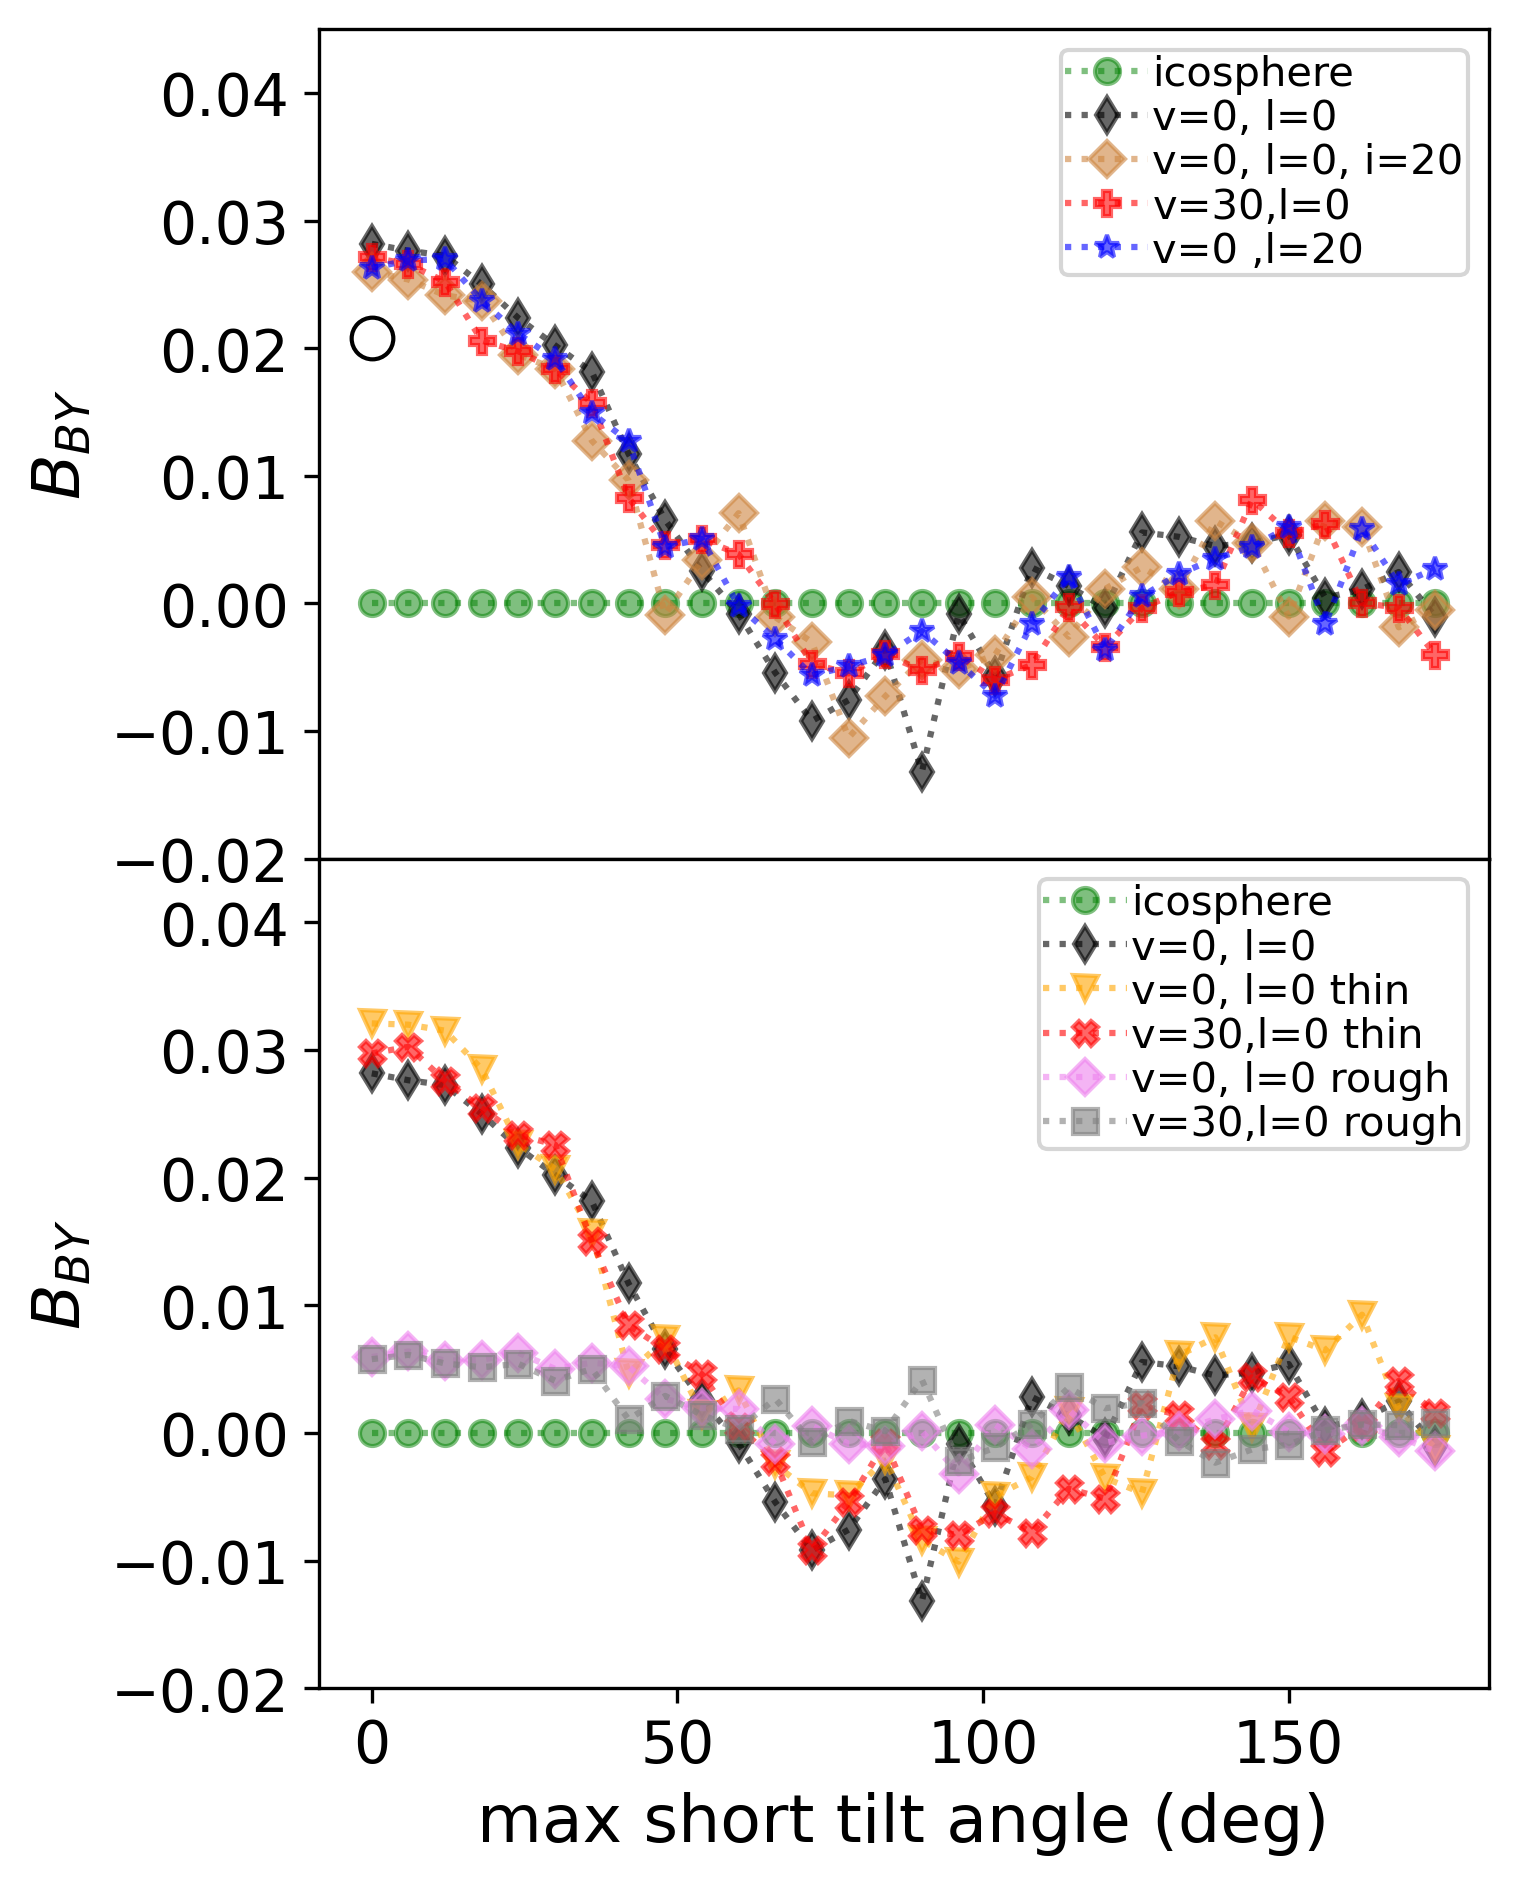

In [46]:
fig,axarr = plt.subplots(2,1,figsize=(5,7),dpi=300,sharex=True,sharey=True)
plt.subplots_adjust(bottom=0.19,top=0.98,left=0.2, right=0.98,wspace=0,hspace=0) 
axarr[0].plot(m_arr_s,mtau_l_arr_s,'go:',alpha=0.5,label='icosphere')
axarr[1].plot(m_arr_s,mtau_l_arr_s,'go:',alpha=0.5,label='icosphere')
axarr[0].set_ylim((-0.02,0.045))


#axarr[0].text(0,0.041,'incl.=0')
#axarr[1].text(0,0.041,'incl.=160')
axarr[0].plot(m_arr_s2,-mtau_l_arr_s2,'d:',alpha=0.6,label=r'v=0, l=0',color='black')
axarr[1].plot(m_arr_s2,-mtau_l_arr_s2,'d:',alpha=0.6,label=r'v=0, l=0',color='black')
axarr[0].plot(m_arr_s4a,-mtau_l_arr_s4a,'D:',alpha=0.6,label=r'v=0, l=0, i=20',color='peru') # i 20
#axarr[1].plot(m_arr_s4b,-mtau_l_arr_s4b,'d:',alpha=0.6,label=r'i=20,v=0, l=0',color='pink') # i=160

#axarr[1].plot(m_arr_s2,-mtau_l_arr_s2,'d:',alpha=0.6,label=r'v=0, p=0',color='black')
axarr[0].plot(m_arr_s4d,-mtau_l_arr_s4d,'P:',alpha=0.6,label=r'v=30,l=0',color='red')
#axarr[1].plot(m_arr_s4e,-mtau_l_arr_s4e,'P:',alpha=0.6,label=r'v=20,l=0',color='red') # i 160
axarr[0].plot(m_arr_s4f,-mtau_l_arr_s4f,'*:',alpha=0.6,label=r'v=0 ,l=20',color='blue')
# axarr[1].plot(m_arr_s4h,-mtau_l_arr_s4h,'*:',alpha=0.6,label=r'v=0 ,l=20',color='blue') # i 160
axarr[1].plot(m_arr_s3, -mtau_l_arr_s3,'v:',alpha=0.6,label=r'v=0, l=0 thin',color='orange')
#axarr[1].plot(m_arr_s3a, -mtau_l_arr_s3a,'v:',alpha=0.6,label=r'v=0, l=0 thin',color='orange')  # i 160
#axarr[0].plot(m_arr_s4i,-mtau_l_arr_s4i,'s:',alpha=0.6,label=r'v=30,l=20',color='brown')
axarr[1].plot(m_arr_s3b, -mtau_l_arr_s3b,'X:',alpha=0.6,label=r'v=30,l=0 thin',color='red')
#axarr[1].plot(m_arr_s4g,-mtau_l_arr_s4g,':',alpha=0.6,label=r'Sq i=160,v=20,p=20',marker='$S$',color='blue')
axarr[1].plot(m_arr_sp,-mtau_l_arr_sp,'D:',alpha=0.6,label=r'v=0, l=0 rough',color='violet')
axarr[1].plot(m_arr_spb,-mtau_l_arr_spb,'s:',alpha=0.6,label=r'v=30,l=0 rough',color='gray')
#axarr[1].plot(m_arr_spa,-mtau_l_arr_spa,'D:',alpha=0.6,label=r'v=0, l=0 rough',color='violet')  #i 160


axarr[1].set_xlabel('max short tilt angle (deg)',fontsize=16)
#ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
axarr[1].set_ylabel(r'$B_{BY}$',fontsize=16)
axarr[0].set_ylabel(r'$B_{BY}$',fontsize=16)
axarr[0].legend(borderpad=0.1,labelspacing=0.1,handletextpad=0.1,loc='upper right',ncol=1)
axarr[1].legend(borderpad=0.1,labelspacing=0.1,handletextpad=0.1,loc='upper right',ncol=1)
#ax.text(72,0.018,'c/a=0.5 b/a=0.7')
Bnom = 2.082e-2
axarr[0].plot([0],[Bnom],marker='o',color='black',fillstyle='none',ms=10)
plt.savefig('tau_BY_tilt.png')

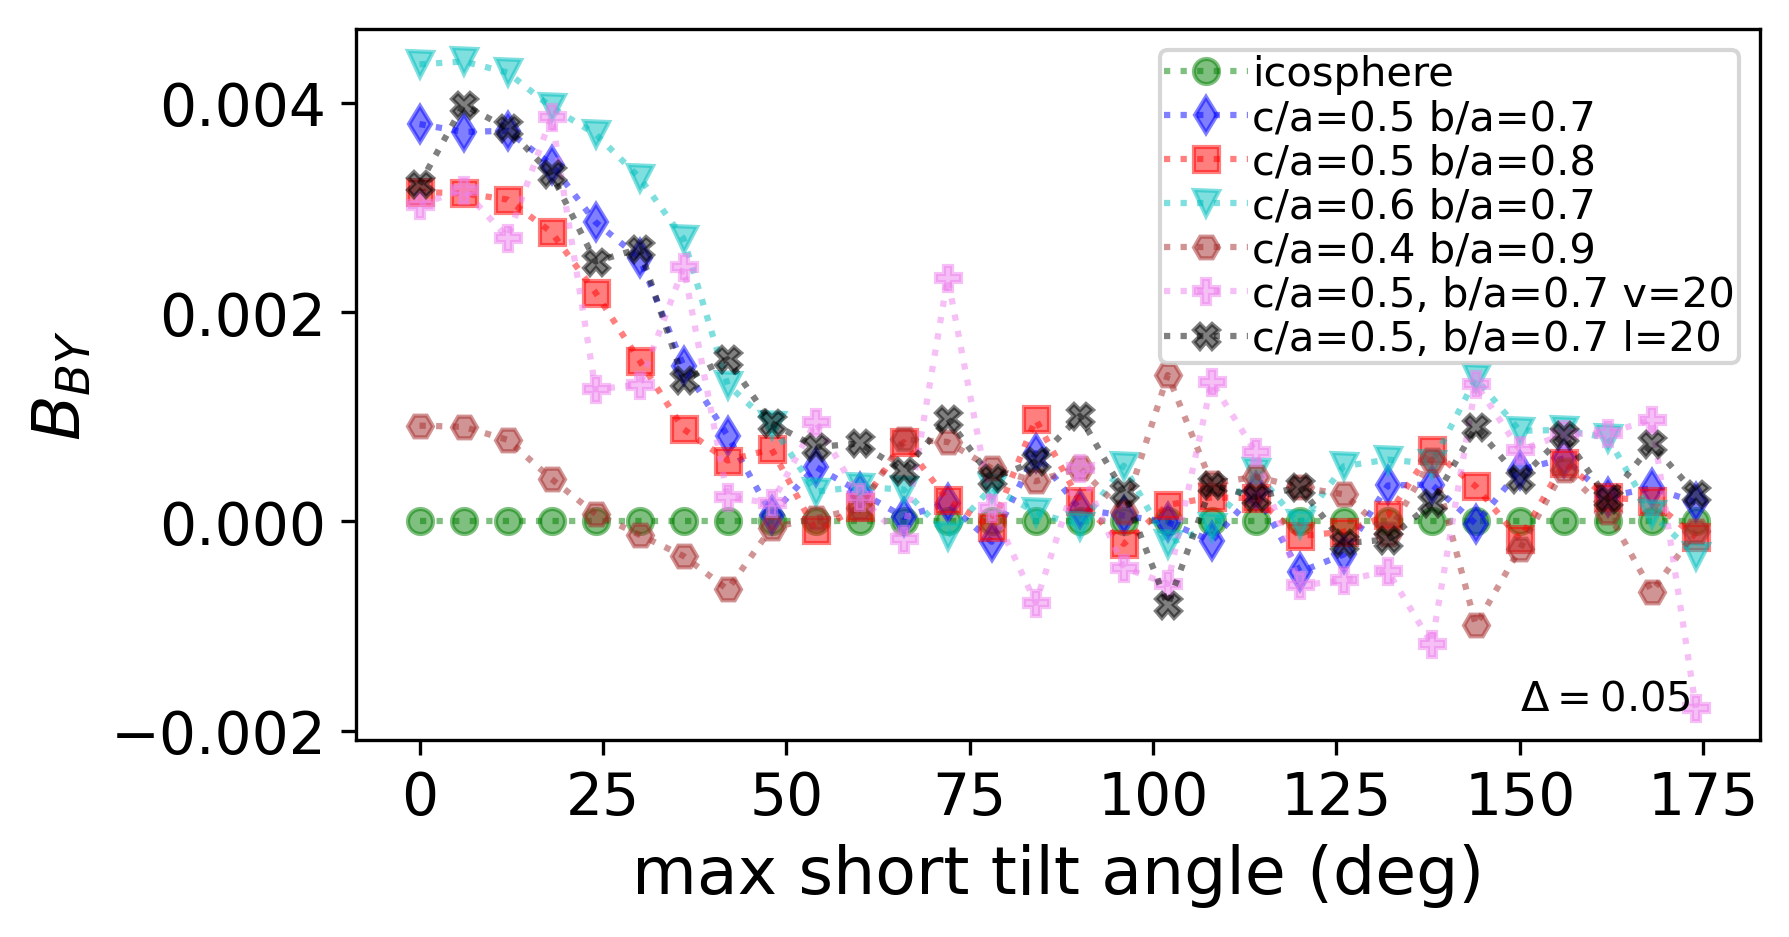

In [34]:
fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=300)
plt.subplots_adjust(bottom=0.19,top=0.98,left=0.2,right=0.98) 

ax.plot(m_arr_s,mtau_l_arr_s,'go:',alpha=0.5,label='icosphere')
ax.plot(m_arr1 ,mtau_l_arr1, 'bd:',alpha=0.5,label=r'c/a=0.5 b/a=0.7')
ax.plot(m_arr1a,mtau_l_arr1a,'rs:',alpha=0.5,label=r'c/a=0.5 b/a=0.8')
ax.plot(m_arr1b,mtau_l_arr1b,'cv:',alpha=0.5,label=r'c/a=0.6 b/a=0.7')
ax.plot(m_arr1c,mtau_l_arr1c,'H:' ,alpha=0.5,label=r'c/a=0.4 b/a=0.9', color='brown')
ax.plot(m_arr1d,mtau_l_arr1d,'P:' ,alpha=0.5,label=r'c/a=0.5, b/a=0.7 v=20', color='violet')
ax.plot(m_arr1e,mtau_l_arr1e,'X:' ,alpha=0.5,label=r'c/a=0.5, b/a=0.7 l=20', color='black')

ax.set_xlabel('max short tilt angle (deg)',fontsize=16)
ax.set_ylabel(r'$B_{BY}$',fontsize=16)
ax.legend(borderpad=0.1,labelspacing=0.1,handletextpad=0.1)
ax.text(150,-0.0018, r'$\Delta=0.05$')
plt.savefig('tau_BY_tilt2.png')

In [35]:
# compute BYORPs as a function of obliquity
incl = 0; phi_prec=0; phi0=0
o_arr1 ,tau_l_arr1 = obliq_BY_fig2(body1.vertices,body1.faces,incl,phi_prec,phi0)
o_arr_s,tau_l_arr_s = obliq_BY_fig2(sphere.vertices,sphere.faces,incl,phi_prec,phi0)

In [36]:
# different perturbations
o_arr2,tau_l_arr2 = obliq_BY_fig2(body2.vertices,body2.faces,incl,phi_prec,phi0)
o_arr3,tau_l_arr3 = obliq_BY_fig2(body3.vertices,body3.faces,incl,phi_prec,phi0)
#o_arr4,tau_l_arr4 = obliq_BY_fig2(body4.vertices,body4.faces,incl,phi_prec,phi0)
o_arr5,tau_l_arr5 = obliq_BY_fig2(body5.vertices,body5.faces,incl,phi_prec,phi0)
o_arr6,tau_l_arr6 = obliq_BY_fig2(body6.vertices,body6.faces,incl,phi_prec,phi0)

In [37]:
# axis ratios
o_arr1a,tau_l_arr1a = obliq_BY_fig2(body1a.vertices,body1a.faces,incl,phi_prec,phi0)
o_arr1b,tau_l_arr1b = obliq_BY_fig2(body1b.vertices,body1b.faces,incl,phi_prec,phi0)
o_arr1c,tau_l_arr1c = obliq_BY_fig2(body1c.vertices,body1c.faces,incl,phi_prec,phi0)

In [27]:
#v_cmshift = np.copy(body6.vertices)
#v_cmshift[:,2] -= 0.05 # shift the center of mass, no affect! 
#o_arr7,tau_l_arr7 = obliq_BY_fig2(v_cmshift,body6.faces,incl,phi_prec,phi0)

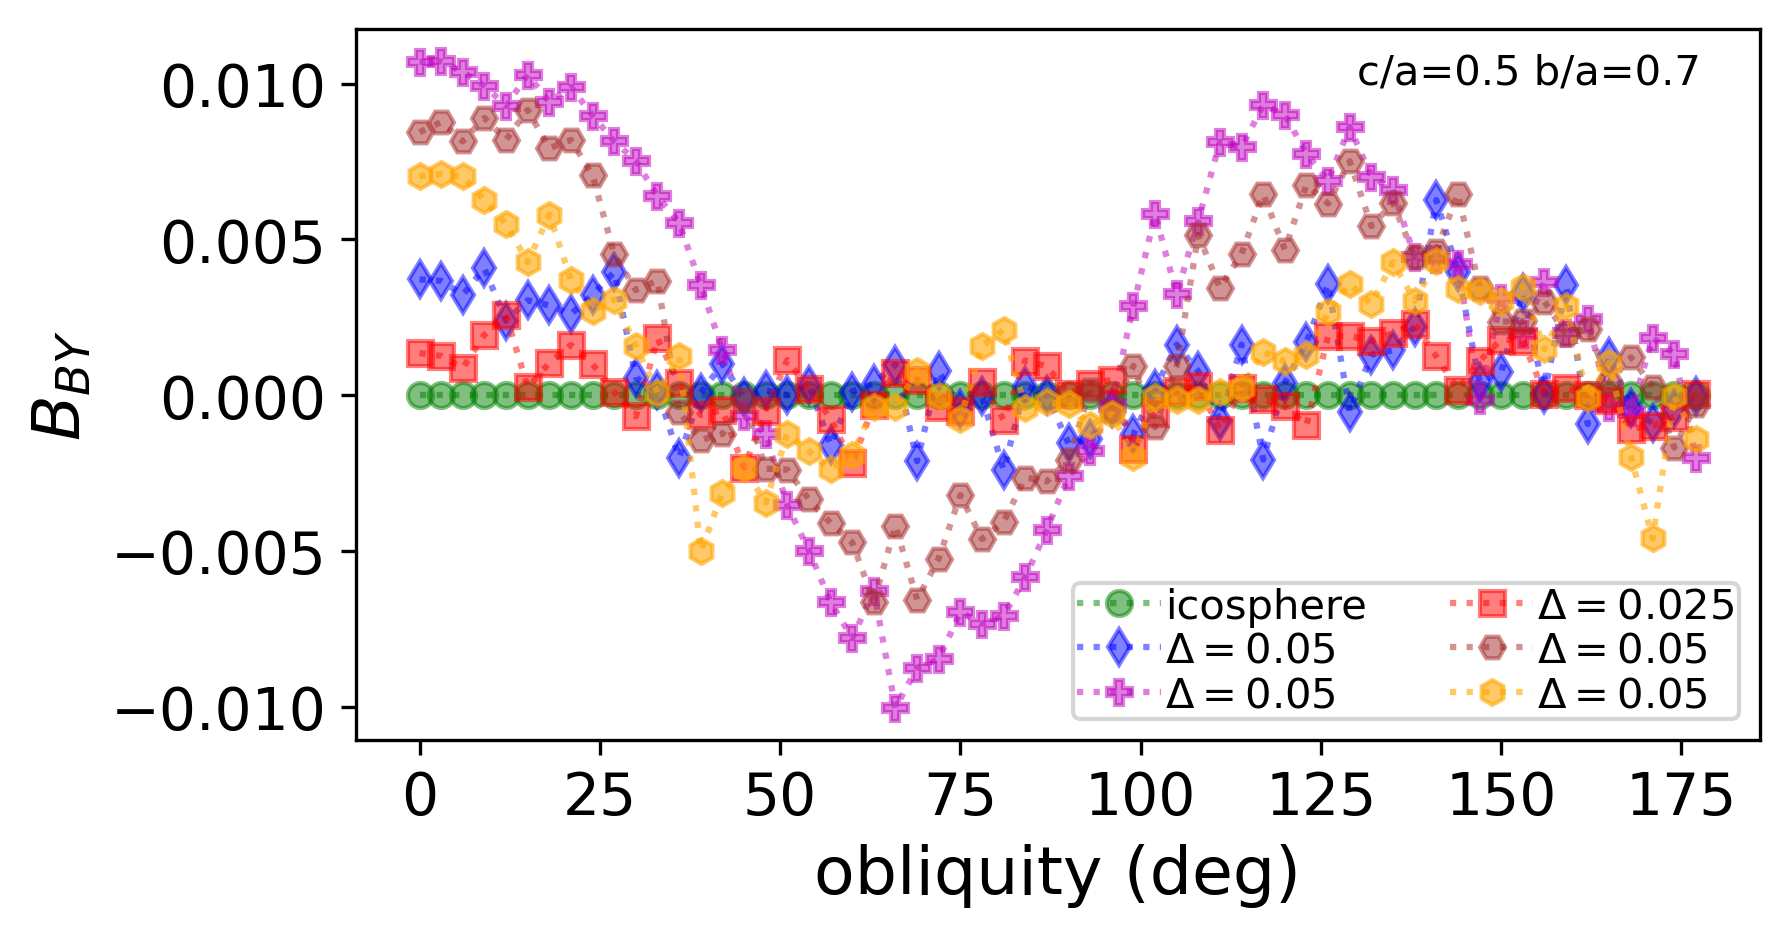

In [38]:
fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=300)
plt.subplots_adjust(bottom=0.19,top=0.98,left=0.2, right=0.98) 
ax.plot(o_arr_s,tau_l_arr_s,'go:',alpha=0.5,label='icosphere')
ax.plot(o_arr1,tau_l_arr1,'bd:',alpha=0.5,label=r'$\Delta=0.05$')
ax.plot(o_arr3,-tau_l_arr3,'mP:',alpha=0.5,label=r'$\Delta=0.05$')
ax.plot(o_arr2,tau_l_arr2,'rs:',alpha=0.5,label=r'$\Delta=0.025$')
#ax.plot(o_arr4,tau_l_arr4,'d:',alpha=0.5,label=r'$\Delta=0.05$',color='gray')
ax.plot(o_arr5,tau_l_arr5,'H:',alpha=0.5,label=r'$\Delta=0.05$',color='brown')
ax.plot(o_arr6,-tau_l_arr6,'h:',alpha=0.6,label=r'$\Delta=0.05$',color='orange')
#ax.plot(o_arr7,-tau_l_arr7,'o:',alpha=0.6,label=r'$\Delta=0.05$',color='black')
ax.set_xlabel('obliquity (deg)',fontsize=16)
#ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.set_ylabel(r'$B_{BY}$',fontsize=16)
ax.legend(borderpad=0.1,labelspacing=0.1,handletextpad=0.1,loc='lower right',ncol=2)
ax.text(130,0.010,'c/a=0.5 b/a=0.7')
plt.savefig('tau_BY_obl.png')

### This is going to zero at high obliquity because spin is counter to rotation of binary

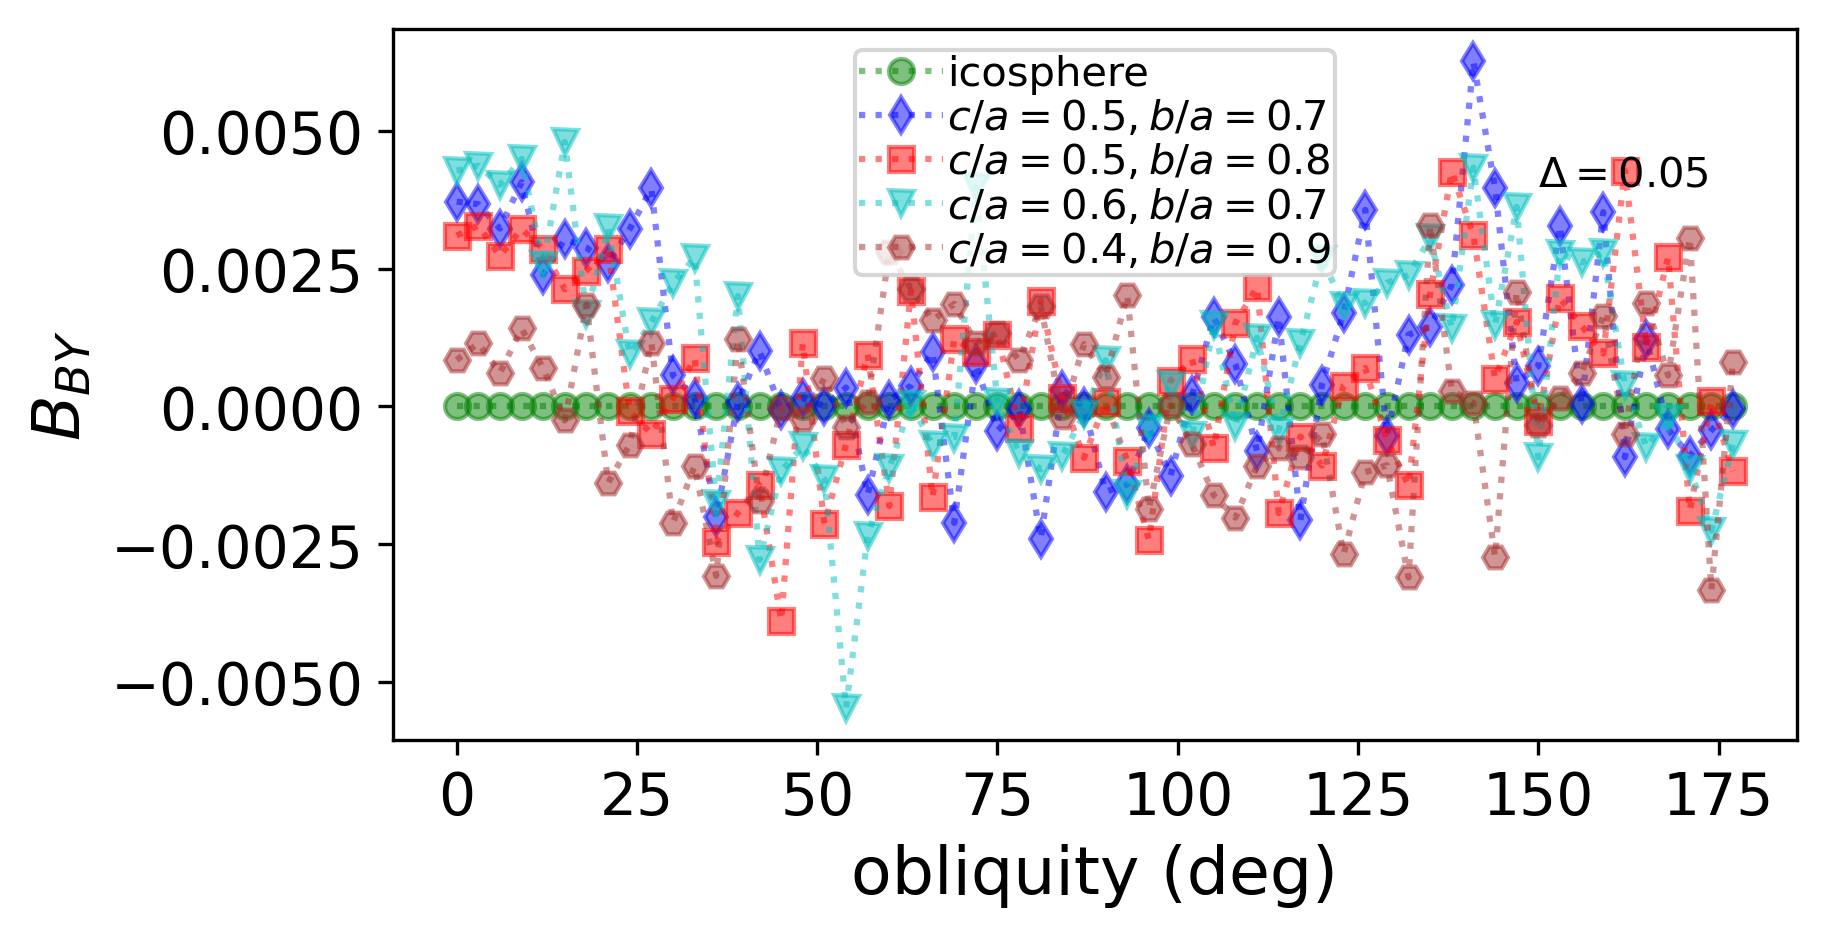

In [39]:
fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=300)
plt.subplots_adjust(bottom=0.19,top=0.98,left=0.2,right=0.98) 

ax.plot(o_arr_s,tau_l_arr_s,'go:',alpha=0.5,label='icosphere')
ax.plot(o_arr1 ,tau_l_arr1, 'bd:',alpha=0.5,label=r'$c/a=0.5, b/a=0.7$')
ax.plot(o_arr1a,tau_l_arr1a,'rs:',alpha=0.5,label=r'$c/a=0.5, b/a=0.8$')
ax.plot(o_arr1b,tau_l_arr1b,'cv:',alpha=0.5,label=r'$c/a=0.6, b/a=0.7$')
ax.plot(o_arr1c,tau_l_arr1c,'H:',alpha=0.5,label=r'$c/a=0.4, b/a=0.9$', color='brown')

ax.set_xlabel('obliquity (deg)',fontsize=16)
#ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.set_ylabel(r'$B_{BY}$',fontsize=16)
ax.legend(borderpad=0.1,labelspacing=0.1,handletextpad=0.1)
ax.text(150,0.004, r'$\Delta=0.05$')
plt.savefig('tau_BY_obl2.png')

In [178]:
print(o_arr1c[0:10])
print(tau_l_arr1c[0:10]) # to see where zero cross is

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]
[ 8.43575358e-04  8.10045222e-04  7.31907874e-04  5.75923007e-04
  2.93785721e-04 -7.84300210e-05 -4.37761971e-04 -7.64313516e-04
 -1.09545806e-03 -1.36557962e-03]


In [40]:
# compute BYORPs as a function of obliquity
incl = 0; phi_prec=0; phi0=0
o_arr_s1,tau_l_arr_s1 = obliq_BY_fig2(short_squannit1.vertices,short_squannit1.faces,incl,phi_prec,phi0)
# compute BYORPs as a function of obliquity
incl = 0; phi_prec=0; phi0=0
o_arr_s2,tau_l_arr_s2 = obliq_BY_fig2(short_squannit2.vertices,short_squannit2.faces,incl,phi_prec,phi0)

In [41]:
# compute BYORPs as a function of obliquity, vary phi_prec
#incl = 0; phi_prec=10*np.pi/180; phi0=0
#o_arr_s3a,tau_l_arr_s3a = obliq_BY_fig2(short_squannit2.vertices,short_squannit2.faces,incl,phi_prec,phi0)
#incl = 0; phi_prec=-10*np.pi/180; phi0=0
#o_arr_s3b,tau_l_arr_s3b = obliq_BY_fig2(short_squannit2.vertices,short_squannit2.faces,incl,phi_prec,phi0)

# compute BYORPs as a function of obliquity, vary incl
incl = 20*np.pi/180; phi_prec=0; phi0=0
o_arr_s4a,tau_l_arr_s4a = obliq_BY_fig2(short_squannit2.vertices,short_squannit2.faces,incl,phi_prec,phi0)
incl = 160*np.pi/180; phi_prec=0; phi0=0
o_arr_s4b,tau_l_arr_s4b = obliq_BY_fig2(short_squannit2.vertices,short_squannit2.faces,incl,phi_prec,phi0)

# compute BYORPs as a function of obliquity, vary lib
incl = 0; phi_prec=0; phi0=20*np.pi/180
o_arr_s5a,tau_l_arr_s5a = obliq_BY_fig2(short_squannit2.vertices,short_squannit2.faces,incl,phi_prec,phi0)
#incl = 0; phi_prec=0; phi0=-20*np.pi/180
#o_arr_s5b,tau_l_arr_s5b = obliq_BY_fig2(short_squannit2.vertices,short_squannit2.faces,incl,phi_prec,phi0)#

In [42]:
#incl = 20*np.pi/180; phi_prec=90.*np.pi/2; phi0=0
#o_arr_s4c,tau_l_arr_s4c = obliq_BY_fig2(short_squannit2.vertices,short_squannit2.faces,incl,phi_prec,phi0)

In [43]:
# compute BYORPs thin squannit
incl = 0; phi_prec=0; phi0=0
o_arr_sta,tau_l_arr_sta = obliq_BY_fig2(short_squannit3.vertices,short_squannit3.faces,incl,phi_prec,phi0)

# compute BYORPs rough squannit
incl = 0; phi_prec=0; phi0=0
o_arr_spa,tau_l_arr_spa = obliq_BY_fig2(short_squannit2_p.vertices,short_squannit2_p.faces,incl,phi_prec,phi0)


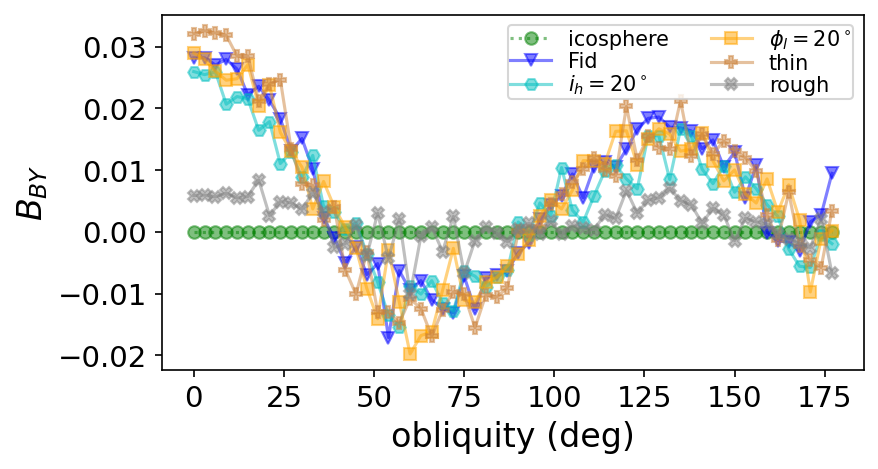

In [45]:
fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=150)
plt.subplots_adjust(bottom=0.19, top = 0.98,left=0.2,right=0.98)

ax.plot(o_arr_s,tau_l_arr_s,'go:',alpha=0.5,label='icosphere')
#ax.plot(o_arr_s1,-tau_l_arr_s1,'rD-',label=r'S302',alpha=0.5)
ax.plot(o_arr_s2,-tau_l_arr_s2,'bv-',label=r'Fid',alpha=0.5)
#ax.plot(o_arr_s3a,tau_l_arr_s3a,'gP-',label=r'S534, $\phi_p=10^\circ$',alpha=0.5)
#ax.plot(o_arr_s3b,tau_l_arr_s3b,'gP-',label=r'S534, $\phi_p=-10^\circ$',alpha=0.5)
ax.plot(o_arr_s4a,-tau_l_arr_s4a,'cH-',label=r'$i_h=20^\circ$',alpha=0.5)
#ax.plot(o_arr_s4c,-tau_l_arr_s4c,'rH-',label=r'$i_h=20^\circ$',alpha=0.5)
#ax.plot(o_arr_s4b,-tau_l_arr_s4b,'cH-',label=r'S534, $i_h=160^\circ$',alpha=0.5)
ax.plot(o_arr_s5a,-tau_l_arr_s5a,'ms-',label=r'$\phi_l=20^\circ$',alpha=0.5,color='orange')
#ax.plot(o_arr_s5b,-tau_l_arr_s5b,'s-',label=r'$\phi_l=-20^\circ$',alpha=0.5)
ax.plot(o_arr_sta,-tau_l_arr_sta,'P-',label=r'thin',alpha=0.5,color='peru')
ax.plot(o_arr_spa,-tau_l_arr_spa,'X-',label=r'rough',alpha=0.5,color='gray')
ax.set_xlabel('obliquity (deg)',fontsize=16)
#ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.set_ylabel(r'$B_{BY}$',fontsize=16)

ax.legend(loc='upper right',borderpad=0.1,labelspacing=0.1,ncol=2)
plt.savefig('squannit.png')

In [41]:
# test tilt_short_axis
xmax = 1.5
vvv = body1.vertices 
phi = np.pi/4; stilt=np.pi/2
vpp,zrot,xrot = tilt_short_axis(vvv,phi,stilt)
print(zrot,xrot)
p = plt_mesh_square(vpp,body1.faces,xmax)

[ 0.70710678 -0.70710678  0.        ] [0.70710678 0.70710678 0.        ]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0057719…

In [59]:
#test tilt_and_bin with short axis tilt
tilt_type=2; nphi=36;iphi=9;phi0=0;tilt_angle2=0; 
tilt_angle1=np.pi/2
vvv = body1.vertices
tvertices,a_bin,l_bin,zrot,xrot =tilt_and_bin(vvv,nphi,iphi,phi0,tilt_type,tilt_angle1,tilt_angle2)
print(zrot,xrot)
print(l_bin,a_bin)
p = plt_mesh_square(tvertices,body1.faces,xmax)

[ 3.66621828e-01 -8.14063990e-17  9.30370053e-01] [2.22044605e-16 1.00000000e+00 0.00000000e+00]
[0. 0. 1.] [6.123234e-17 1.000000e+00 0.000000e+00]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0056651…